## Creating function: &thinsp; First-order conservative regridding

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [46]:
def plot_snapshot(var, cmap, variable_name, model):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, model:' + model)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

### grid in

In [26]:
model='GFDL-CM3'
experiment='historical'
ds_in = xr.open_dataset(home + '/Documents/data/cmip5/ds' + '/' + model + '_pr4_orig_' + experiment + '.nc')
M_in = ds_in.pr.isel(time=0)
M_in

<xarray.DataArray 'pr' (lat: 30, lon: 144)>
array([[4.342670e-06, 3.116653e-06, 2.758290e-06, ..., 6.019024e-06,
        6.127762e-06, 5.426103e-06],
       [4.517907e-06, 2.389717e-06, 2.283968e-06, ..., 7.076801e-06,
        6.953840e-06, 5.739020e-06],
       [2.954293e-06, 1.170665e-06, 6.880700e-07, ..., 6.762687e-06,
        4.822350e-06, 5.781574e-06],
       ...,
       [8.050560e-09, 4.638842e-09, 2.464906e-13, ..., 0.000000e+00,
        0.000000e+00, 1.430407e-09],
       [7.862324e-10, 1.022034e-08, 5.661345e-10, ..., 4.685636e-15,
        8.917287e-15, 2.917019e-10],
       [9.861120e-12, 2.545958e-10, 5.228667e-10, ..., 2.292482e-09,
        3.778469e-09, 6.628639e-11]], dtype=float32)
Coordinates:
    time     object 1970-01-01 12:00:00
  * lat      (lat) float64 -29.0 -27.0 -25.0 -23.0 -21.0 ... 23.0 25.0 27.0 29.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Attributes:
    long_name:         Precipitation
    units:             kg m-2 s-1
    cell_methods:      time: mean
    interp_method:     conserve_order1
    standard_name:     precipitation_flux
    original_units:    kg/m2/s
    original_name:     precip
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

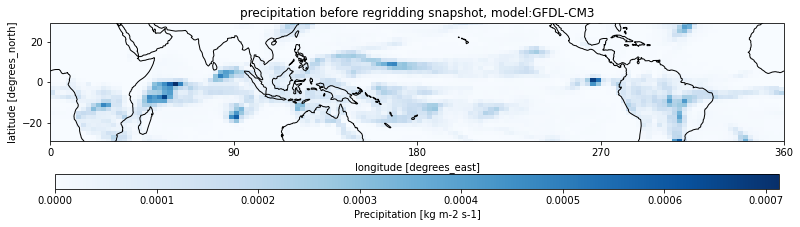

In [48]:
plot_snapshot(M_in, 'Blues', 'precipitation before regridding',model)
#M_in.plot()

### grid out / new matrix dimensions

In [49]:
M_out = xr.open_dataset(home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')
M_out

<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, lat: 22, lon: 128)
Coordinates:
  * time       (time) object 1970-01-01 12:00:00
  * lat        (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/29)
    history:                 N/A 2012-07-04T15:21:17Z CMOR rewrote data to co...
    branch_time:             160235.0
    product:                 output
    model_id:                FGOALS_g2
    frequency:               day
    source:                  FGOALS_g2 2011 atmosphere: GAMIL (gamil2, 128x60...
    ...                      ...
    Conventions:             CF-1.4
    realization:             1
    project_id:              CMIP5
    physics_version:         1
    parent_experiment_rip:   r1i1p1
    intake_esm_dataset_key:  cmip5.output1.LASG-CESS.FGOALS-g2.historical.day...

### weights

In [50]:
dlat = M_in.lat.data[1]-M_in.lat.data[0]
dlon = M_in.lon.data[1]-M_in.lon.data[0]
latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
lat = np.mean(latBnds, axis=0)
lon = np.mean(lonBnds, axis=0)
# area of gridboxes as fraction of earth surface area
area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

In [51]:
dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
lat_n = np.mean(latBnds_n, axis=0)
lon_n = np.mean(lonBnds_n, axis=0)

In [52]:
Wlat = np.zeros([len(lat_n), len(lat)])
for i in np.arange(0,len(lat_n)):
    latBoxMin_n = latBnds_n[0][i]
    latBoxMax_n = latBnds_n[1][i]

    # gridboxes that are atleast partially overlapping with iteration gridbox
    J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

    # including fractional area component contribution
    I = J*(latBnds[1]-latBoxMin_n)/dlat
    K = J*(latBoxMax_n-latBnds[0])/dlat
    II = np.min([I,J,K], axis=0)

    # weights from individual gridboxes in 'grid in' contributing to the new gridbox as fraction of the total combined area contribution
    Wlat[i,:] = II/np.sum(II)


In [53]:
Wlon = np.zeros([len(lon_n), len(lon)])
for i in np.arange(0,len(lon_n)):
    lonBoxMin_n = lonBnds_n[0][i]
    lonBoxMax_n = lonBnds_n[1][i]

    # gridboxes that are atleast partially overlapping with iteration gridbox
    J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

    # Including fractional area component contribution
    I = J*(lonBnds[1]-lonBoxMin_n)/dlon
    K = J*(lonBoxMax_n-lonBnds[0])/dlon
    L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
    II = np.min([I,J,K,L], axis=0)

    # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
    Wlon[i,:] = II/np.sum(II)

### interpolation

In [54]:
M_Wlat = np.zeros([len(lat_n), len(lon)])
for i in range(0, np.shape(Wlat)[0]):
    
    M_Wlat[i,:] = np.nansum(M_in * np.vstack(Wlat[i,:]),axis=0)/np.sum(~np.isnan(M_in)*1*np.vstack(Wlat[i,:]),axis=0)


In [55]:
M_n = np.zeros([len(lat_n), len(lon_n)])
for i in range(0, np.shape(Wlon)[0]):
    
    M_n[:,i] = np.nansum(M_Wlat * Wlon[i,:],axis=1)/np.sum(~np.isnan(M_Wlat)*1*Wlon[i,:], axis=1)



In [60]:
M_n = xr.DataArray(
    data = M_n,
    dims = ['lat', 'lon'],
    coords = {'lat': M_out.lat.data, 'lon': M_out.lon.data},
    attrs = M_in.attrs
    )

In [64]:
# plot_snapshot(M_n, 'Blues', 'precipitation after regridding',model)
# M_n.plot()

### function (weights + interpolation)

In [35]:
M_in = xr.open_dataset(home + '/Documents/data/cmip5/ds/' + 'GFDL-CM3' + '_pr4_orig_' + 'historical' + '.nc').pr.isel(time=slice(0,2))

In [36]:
def regrid_conserv_np(M_in):

    # dimensions of model to regrid to
    M_out = xr.open_dataset(home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')['pr']

    # dimensions
    dlat = M_in.lat.data[1]-M_in.lat.data[0]
    dlon = M_in.lon.data[1]-M_in.lon.data[0]
    latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
    lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
    lat = np.mean(latBnds, axis=0)
    lon = np.mean(lonBnds, axis=0)
    # area of gridboxes as fraction of earth surface area
    area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

    dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
    dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
    latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
    lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
    lat_n = np.mean(latBnds_n, axis=0)
    lon_n = np.mean(lonBnds_n, axis=0)

    # weights
    Wlat = np.zeros([len(lat_n), len(lat)])
    for i in np.arange(0,len(lat_n)):
        latBoxMin_n = latBnds_n[0][i]
        latBoxMax_n = latBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

        # including fractional area component contribution
        I = J*(latBnds[1]-latBoxMin_n)/dlat
        K = J*(latBoxMax_n-latBnds[0])/dlat
        II = np.min([I,J,K], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlat[i,:] = II/np.sum(II)

    Wlon = np.zeros([len(lon_n), len(lon)])
    for i in np.arange(0,len(lon_n)):
        lonBoxMin_n = lonBnds_n[0][i]
        lonBoxMax_n = lonBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

        # Including fractional area component contribution
        I = J*(lonBnds[1]-lonBoxMin_n)/dlon
        K = J*(lonBoxMax_n-lonBnds[0])/dlon
        L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
        II = np.min([I,J,K,L], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlon[i,:] = II/np.sum(II)

    # interpolation
    M_n = np.zeros([len(M_in.time.data), len(lat_n), len(lon_n)])
    for day in np.arange(0,len(M_in.time.data)):
        M_Wlat = np.zeros([len(lat_n), len(lon)])

        for i in range(0, np.shape(Wlat)[0]):
            M_Wlat[i,:] = np.nansum(M_in.isel(time=day) * np.vstack(Wlat[i,:]),axis=0)/np.sum(~np.isnan(M_in.isel(time=day))*1*np.vstack(Wlat[i,:]),axis=0)
            
        for i in range(0, np.shape(Wlon)[0]):
            M_n[day,:,i] = np.nansum(M_Wlat * Wlon[i,:],axis=1)/np.sum(~np.isnan(M_Wlat)*1*Wlon[i,:], axis=1)

    return M_n, M_out


In [40]:
M_n, M_out = regrid_conserv_np(M_in)

In [42]:
M_n = xr.DataArray(
    data = M_n,
    dims = ['time', 'lat', 'lon'],
    coords = {'time': M_in.time.data, 'lat': M_out.lat.data, 'lon': M_out.lon.data},
    attrs = M_in.attrs
)

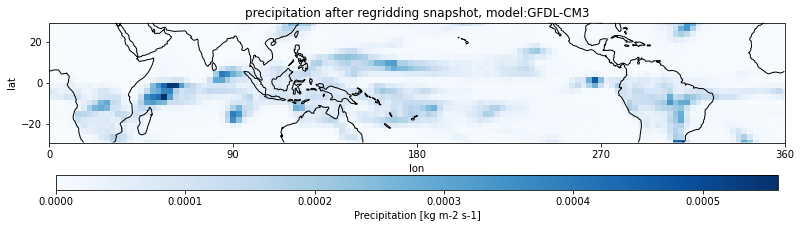

In [43]:
plot_snapshot(M_n.isel(time=0), 'Blues', 'precipitation after regridding',model)

## Include dealing with grid with vertical coordinate (plev), <br> and using xarray operations

In [ ]:
# just need to broadcast weights in lat and lon to plev in M_in

# could make the weights into xarray data arrays, then the broadcasting should be correct automatically

In [46]:
M_in = xr.open_dataset(home + '/Documents/data/cmip5/ds/' + 'GFDL-CM3' + '_pr4_orig_' + 'historical' + '.nc').pr.isel(time=slice(0,2))

In [3]:
M_in = xr.open_dataset(home + '/Documents/data/cmip6/' + 'ds' + '/' + 'MPI-ESM1-2-HR_mse_historical_1987.nc').mse_year.isel(time=slice(0,2))

In [65]:
M_in

<xarray.DataArray 'mse_year' (time: 2, plev: 8, lat: 64, lon: 384)>
[393216 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1987-01-01T12:00:00 1987-01-02T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1

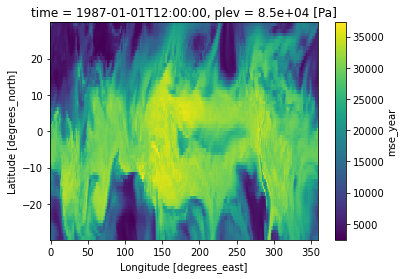

In [67]:
M_in.isel(time=0).sel(plev=850e2).plot()

In [80]:
def regrid_conserv(M_in):

    # dimensions of model to regrid to
    M_out = xr.open_dataset(home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc')['pr']

    # dimensions
    dlat = M_in.lat.data[1]-M_in.lat.data[0]
    dlon = M_in.lon.data[1]-M_in.lon.data[0]
    latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
    lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
    lat = np.mean(latBnds, axis=0)
    lon = np.mean(lonBnds, axis=0)
    # area of gridboxes as fraction of earth surface area
    area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

    dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
    dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
    latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
    lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
    lat_n = np.mean(latBnds_n, axis=0)
    lon_n = np.mean(lonBnds_n, axis=0)

    # weights
    Wlat = np.zeros([len(lat_n), len(lat)])
    for i in np.arange(0,len(lat_n)):
        latBoxMin_n = latBnds_n[0][i]
        latBoxMax_n = latBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

        # including fractional area component contribution
        I = J*(latBnds[1]-latBoxMin_n)/dlat
        K = J*(latBoxMax_n-latBnds[0])/dlat
        II = np.min([I,J,K], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlat[i,:] = II/np.sum(II)

    Wlat = xr.DataArray(
        data = Wlat,
        dims = ['lat_n', 'lat']
        )

    Wlon = np.zeros([len(lon_n), len(lon)])
    for i in np.arange(0,len(lon_n)):
        lonBoxMin_n = lonBnds_n[0][i]
        lonBoxMax_n = lonBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

        # Including fractional area component contribution
        I = J*(lonBnds[1]-lonBoxMin_n)/dlon
        K = J*(lonBoxMax_n-lonBnds[0])/dlon
        L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
        II = np.min([I,J,K,L], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlon[i,:] = II/np.sum(II)

    Wlon = xr.DataArray(
        data = Wlon,
        dims = ['lon_n', 'lon']
        )

    # interpolation
    if ('plev' or 'lev') in M_in.dims:
        if 'lev' in M_in.dims:
            M_n = M_n.rename({'lev': 'plev'})

        M_n = xr.DataArray(
            data = np.zeros([len(M_in.time.data), len(M_in.plev.data), len(lat_n), len(lon_n)]),
            dims = ['time', 'plev', 'lat_n', 'lon_n'],
            coords = {'time': M_in.time.data, 'plev': M_in.plev.data, 'lat_n': M_out.lat.data, 'lon_n': M_out.lon.data},
            attrs = M_in.attrs
            )

        for day in np.arange(0,len(M_in.time.data)):
            
            M_Wlat = xr.DataArray(
            data = np.zeros([len(M_in.plev), len(lat_n), len(lon)]),
            dims = ['plev', 'lat_n', 'lon']
            )

            for i in range(0, len(Wlat.lat_n)):
                M_Wlat[:,i,:] = (M_in.isel(time=day) * Wlat[i,:]).sum(dim='lat', skipna=True) / (M_in.isel(time=day).notnull()*1*Wlat[i,:]).sum(dim='lat')
                
            for i in range(0, len(Wlon.lon_n)):
                M_n[day,:,:,i] = (M_Wlat * Wlon[i,:]).sum(dim='lon', skipna=True) / (M_Wlat.notnull()*1*Wlon[i,:]).sum(dim='lon')


    else:
        M_n = xr.DataArray(
            data = np.zeros([len(M_in.time.data), len(lat_n), len(lon_n)]),
            dims = ['time', 'lat_n', 'lon_n'],
            coords = {'time': M_in.time.data, 'lat_n': M_out.lat.data, 'lon_n': M_out.lon.data},
            attrs = M_in.attrs
            )

        for day in np.arange(0,len(M_in.time.data)):

            M_Wlat = xr.DataArray(
            data = np.zeros([len(lat_n), len(lon)]),
            dims = ['lat_n', 'lon']
            )

            for i in range(0, len(Wlat.lat_n)):
                M_Wlat[i,:] = (M_in.isel(time=day) * Wlat[i,:]).sum(dim='lat', skipna=True) / (M_in.isel(time=day).notnull()*1*Wlat[i,:]).sum(dim='lat')
                
            for i in range(0, len(Wlon.lon_n)):
                M_n[day,:,i] = (M_Wlat * Wlon[i,:]).sum(dim='lon', skipna=True) / (M_Wlat.notnull()*1*Wlon[i,:]).sum(dim='lon')


    M_n = M_n.rename({'lat_n': 'lat', 'lon_n': 'lon'})
    
    return M_n


In [81]:
M_n = regrid_conserv(M_in)

In [82]:
M_n

<xarray.DataArray (time: 2, plev: 8, lat: 22, lon: 128)>
array([[[[25761.83715452, 25812.29866196, 25134.12660902, ...,
          26726.99697893, 26072.57584665, 25865.33095497],
         [25523.20934685, 25132.14262505, 25343.08097213, ...,
          27535.18688306, 27010.93488912, 26182.41296178],
         [24629.21116482, 24611.83115769, 25213.73541044, ...,
          28213.75934847, 27273.22489024, 25978.69297748],
         ...,
         [ 4538.78628161,  4992.30904999,  3446.90513463, ...,
           8586.14750384,  4625.719375  ,  4163.84196188],
         [ 4217.29371086,  4696.06092284,  4291.85266489, ...,
          18099.69105991, 13747.0801718 ,  6287.38528319],
         [ 6692.0941548 ,  4604.14173973,  5070.91680106, ...,
          17800.21350521, 17356.35515967, 15210.18284472]],

        [[14170.41954525, 13091.89251054, 11059.86233793, ...,
          12232.93399863, 13177.08075146, 13752.16220513],
         [12039.97428689, 11942.4464003 ,  9761.11890738, ...,
          14097.60211176, 12200.33658757, 11834.15817089],
         [ 7736.40024328,  6386.17295992,  4862.24661207, ...,
          16595.9741568 , 13852.85592939, 10988.95495414],
...
         [20696.26805575, 20700.78469499, 20705.72278399, ...,
          20683.23412886, 20686.59275283, 20691.31157994],
         [20671.62567522, 20675.10144269, 20680.39678139, ...,
          20663.08675354, 20664.81208896, 20667.9030368 ],
         [20649.02524206, 20651.12004761, 20654.76630707, ...,
          20643.5338872 , 20645.18393965, 20646.01357679]],

        [[31268.55942627, 31271.05045791, 31274.045082  , ...,
          31269.86617467, 31270.73413815, 31269.36336137],
         [31231.96480218, 31234.27729653, 31239.15171491, ...,
          31231.94288439, 31232.92945622, 31233.23388534],
         [31192.5847308 , 31192.58537168, 31197.85221935, ...,
          31188.60272576, 31190.0204452 , 31191.64198457],
         ...,
         [30907.37969253, 30912.66021606, 30921.11237522, ...,
          30885.42101493, 30892.47055737, 30899.7045513 ],
         [30837.54388508, 30841.81428151, 30852.08770729, ...,
          30819.7003797 , 30826.96069284, 30833.42094835],
         [30768.4281163 , 30771.18310321, 30779.81503432, ...,
          30751.93580093, 30758.96866685, 30764.2028889 ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1987-01-01T12:00:00 1987-01-02T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

In [77]:
M_n.plev

<xarray.DataArray 'plev' (plev: 8)>
array([100000.,  85000.,  70000.,  50000.,  25000.,  10000.,   5000.,   1000.])
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03

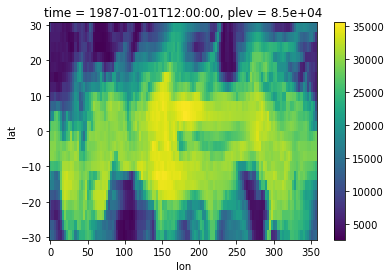

In [83]:
M_n.isel(time=0).sel(plev=850e2).plot()

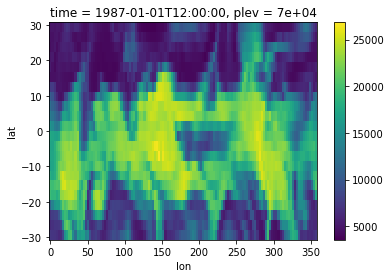

In [84]:
M_n.isel(time=0).sel(plev=700e2).plot()